# Saving and Loading a PyTorch Model
First let's recreate setup from previous example, so we have a trained model to save.

In [6]:
# project setup
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device is: {device}")

# data setup
x = [[1,2],[3,4],[5,6],[7,8]]
y = [[3],[7],[11],[15]]

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x).float().to(device)
        self.y = torch.tensor(y).float().to(device)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

dataset = MyDataset(x, y)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True) 

# model setup
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
).to(device)

summary(model, torch.zeros(1,2))

Device is: cuda
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 8]                   24
├─ReLU: 1-2                              [-1, 8]                   --
├─Linear: 1-3                            [-1, 1]                   9
Total params: 33
Trainable params: 33
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 8]                   24
├─ReLU: 1-2                              [-1, 8]                   --
├─Linear: 1-3                            [-1, 1]                   9
Total params: 33
Trainable params: 33
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

Text(0, 0.5, 'loss value')

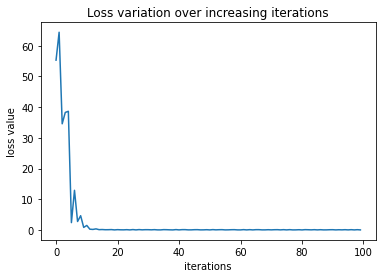

In [7]:
# model training
from ast import increment_lineno


loss_func = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.001)
loss_history = []
for _ in range(50):
    for ix, iy in dataloader:
        opt.zero_grad()
        loss_value  = loss_func(model(ix), iy)
        loss_value.backward()
        opt.step()
        loss_history.append(loss_value.cpu().detach().numpy())

%matplotlib inline
plt.plot(loss_history)
plt.title('Loss variation over increasing iterations')
plt.xlabel('iterations')
plt.ylabel('loss value')

*Previous setup is now recreated.*

One of the important aspects of working on neural network models is to save and load back a model after training.
Think of a scenario where you have to make inferences from an already-trained model. You would load the trained model instead of training it again.

## state dict
The dictionary in `model.state_dict()` corresponds to the parameters names (keys) and the values (weight and bias values) corresponding to the model. `state` refers to the current snapshot of the model (where the snapshot is the set of values at each tensor).

It returns a dictionary (`OrderedDict`) of keys and values:

In [8]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5636,  0.3664],
                      [ 0.4716,  0.4239],
                      [-0.5666, -0.5802],
                      [ 0.5389,  0.8061],
                      [ 0.2479,  0.6308],
                      [ 0.2639, -0.5479],
                      [-0.6411, -0.1130],
                      [-0.2415,  0.0823]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.6647, -0.4040, -0.6597,  0.5572, -0.2768, -0.2715, -0.6497, -0.3278],
                     device='cuda:0')),
             ('2.weight',
              tensor([[ 0.0871,  0.3490,  0.2898,  0.8298,  0.5722, -0.2677,  0.0148,  0.0772]],
                     device='cuda:0')),
             ('2.bias', tensor([0.0254], device='cuda:0'))])

## Saving
Running `torch.save(model.state_dict(), 'mymodel.pth')` will save this model in a Python serialized format on the disk with the name `mymodel.pth` **A good practice** is to transfer the model to the CPU before calling `torch.save` as this will save tensors as CPU tensors and not as CUDA tensors. This will help in loading the model onto any machine, wheter it contains CUDA capabilities or not.

In [11]:
torch.save(model.to('cpu').state_dict(), 'mymodel.pth')

## Loading
Loading a model requires us to initialize the new model with random weights and the load the weights from `state_dict`

1. Create an empty model with the same command that was use in the first place when training:

In [12]:
recreated_model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
).to(device)

2. Load the previously saved model from disk:

In [13]:
state_dict = torch.load('mymodel.pth')

3. Load `state_dict` onto `recreated_model`, register to `device` and make a prediction.

In [14]:
recreated_model.load_state_dict(state_dict)
recreated_model.to(device)

v = [[8,9], [10,11], [12,13]]
validation = torch.tensor(v).float().to(device)
print("expected: ", [a+b for a, b in v])
print("validation:", recreated_model(validation).view(1, 3))

expected:  [17, 21, 25]
validation: tensor([[16.8173, 20.6800, 24.5428]], device='cuda:0', grad_fn=<ViewBackward0>)
